## load libraries

In [1]:
import pandas as pd
import geopandas as gpd
import folium

from shapely.geometry import Polygon, Point
import numpy as np
import xarray as xr
import random
import os
import time
import re
import math

import matplotlib.pyplot as plt
import altair as alt

In [2]:
# Set GeoPandas to use pyogrio
gpd.options.io_engine = "pyogrio"

## folium map generator function

In [3]:
# List of available tiles with their attributions and layer names (including USGS maps)
tiles_list = [
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Topo"},
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Imagery"},
    {"tiles": "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryTopo/MapServer/tile/{z}/{y}/{x}", "attr": 'U.S. Department of the Interior | U.S. Geological Survey', "name": "USGS Imagery Topo"},
    {"tiles": "OpenStreetMap", "attr": "© OpenStreetMap contributors", "name": "OpenStreetMap"},
    {"tiles": "https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png", "attr": '&copy; <a href="https://stadiamaps.com/" target="_blank">Stadia Maps</a> <a href="https://stamen.com/" target="_blank">&copy; Stamen Design</a> &copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a> &copy; <a href="https://www.openstreetmap.org/copyright" target="_blank">OpenStreetMap</a>', "name": "Stamen Toner Lite"},
]

def generate_folium_map_with_csb_centroids_and_colors(gdf, zoom=6, decimal_places=3):
    # Check CRS and convert to EPSG:4326 if needed
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)
    
    # Format latitude and longitude to the desired number of decimal places
    gdf['Longitude_formatted'] = gdf['Longitude'].map(lambda x: f'{x:>{decimal_places+4}.{decimal_places}f}')
    gdf['Latitude_formatted'] = gdf['Latitude'].map(lambda x: f'{x:>{decimal_places+4}.{decimal_places}f}')
    
    # Ensure necessary columns are included in the properties
    gdf = gdf[['geometry', 'CDL2023', 'Longitude', 'Latitude', 'Longitude_formatted', 'Latitude_formatted', 'color', 'Crop', 'Elevation']]
    
    def style_function(feature):
        return {
            'fillColor': feature['properties']['color'],
            'color': feature['properties']['color'],
            'weight': 1,
            'fillOpacity': 0.6
        }

    # Create a separate GeoDataFrame for the centroids
    centroids_gdf = gdf.copy()
    # centroids_gdf['geometry'] = centroids_gdf.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    centroids_gdf['geometry'] = gpd.points_from_xy(centroids_gdf['Longitude'], centroids_gdf['Latitude'])
    
    # Convert geometries to GeoJSON
    geojson_data = gdf.to_json()
    centroids_geojson_data = centroids_gdf.to_json()
    
    # Calculate map center
    minx, miny, maxx, maxy = gdf.total_bounds
    center_longitude = (minx + maxx) / 2
    center_latitude = (miny + maxy) / 2
    
    # Initialize map
    m = folium.Map(location=[center_latitude, center_longitude], zoom_start=zoom, tiles=None)
    
    # Add each tile layer to the map
    for tile_info in tiles_list:
        tiles = tile_info["tiles"]
        attr = tile_info["attr"]
        layer_name = tile_info["name"]
        folium.TileLayer(tiles=tiles, attr=attr, name=layer_name).add_to(m)
    
    # Add GeoJSON layer with custom popups and styles for crop sequence boundaries
    folium.GeoJson(
        geojson_data,
        name='Crop Sequence Boundaries',
        style_function=style_function,
        popup=folium.GeoJsonPopup(fields=['CDL2023', 'Crop', 'Latitude_formatted', 'Longitude_formatted','Elevation'], aliases=['Crop ID:', 'Crop:', 'Latitude:', 'Longitude:', 'Elevation:'])
    ).add_to(m)
    
    # Add GeoJSON layer for centroids with custom CircleMarkers
    folium.GeoJson(
        centroids_geojson_data,
        name='CSB Centroids',
        # marker=folium.CircleMarker(radius=4, fill_color='grey', fill_opacity=1, color='grey', weight=0.2),
        marker=folium.CircleMarker(
            radius=4, 
            fill=True,
            fill_opacity=0.8,
            weight=0.2
        ),
        # marker=folium.CircleMarker(radius=4),
        style_function=lambda x: {'fillColor': x['properties']['color'], 'color': 'grey'},
        popup=folium.GeoJsonPopup(fields=['CDL2023', 'Crop', 'Latitude_formatted', 'Longitude_formatted', 'Elevation'], aliases=['Crop ID:', 'Crop:', 'Latitude:', 'Longitude:', 'Elevation:']),
    ).add_to(m)
    
    # Add layer control to the map
    folium.LayerControl().add_to(m)
    
    return m

In [4]:
# generate_folium_map_with_csb_centroids_and_colors(geo_balanced_csb_samples)

## load crop sequence boundaries

In [5]:
# sample_data_file = '../data/agricultural/CSB/siads696/geo_balanced_sample.parquet'
sample_data_file = '../data/fields/geo_balanced_sample.parquet'
geo_balanced_csb_samples = gpd.read_parquet(sample_data_file)
geo_balanced_csb_samples

CSBID CSBYEARS   CSBACRES  CDL2016  CDL2017  CDL2018  \
478801  081623012787392     1623   3.791540        4       24       61   
107446  351623001627247     1623   4.325446      225        1      225   
121162  351623002777545     1623   3.222010       61      176        1   
88813   351623000046581     1623  10.204036       36       36       36   
516266  081623013377366     1623   2.918481       24       29       29   
...                 ...      ...        ...      ...      ...      ...   
119071  351623002568175     1623   2.957066      176      176      176   
540278  081623014401456     1623   9.374885       61       24       61   
591949  041623013556134     1623   3.770585       72       72       72   
217842  081623005639708     1623   4.307316       61       24        1   
308295  081623008142809     1623   2.358687       24       24       24   

        CDL2019  CDL2020  CDL2021  CDL2022  ...      INSIDE_X      INSIDE_Y  \
478801       61       24       24       61  ... -6.035779e+05  1.704774e+06   
107446      152      152      152       36  ... -7.967410e+05  1.149389e+06   
121162      176       36       36        1  ... -1.086137e+06  1.590736e+06   
88813        36      152       37       37  ... -9.788489e+05  1.595846e+06   
516266       24        1       61       61  ... -6.203751e+05  1.992249e+06   
...         ...      ...      ...      ...  ...           ...           ...   
119071       61       24       24       24  ... -9.138551e+05  1.348095e+06   
540278        1        1        1        1  ... -6.892023e+05  1.934718e+06   
591949      190      190      190      190  ... -1.707418e+06  1.273220e+06   
217842       61       24       29       61  ... -6.004245e+05  1.898598e+06   
308295      176      176      176      176  ... -6.305569e+05  1.799453e+06   

            Shp_Len      Shp_Area  \
478801   532.211689  15343.877410   
107446   723.964572  17504.529797   
121162   549.623304  13039.063523   
88813   1274.741723  41294.433943   
516266   556.566951  11810.721459   
...             ...           ...   
119071   599.379620  11966.871324   
540278   988.353218  37938.965442   
591949   523.387689  15259.076277   
217842   634.862780  17431.160158   
308295   561.322645   9545.307371   

                                                 geometry   Longitude  \
478801  MULTIPOLYGON (((-603525.799 1704829.066, -6035... -102.962080   
107446  MULTIPOLYGON (((-796679.747 1149498.895, -7966... -104.600667   
121162  MULTIPOLYGON (((-1086091.187 1590803.212, -108... -108.309751   
88813   MULTIPOLYGON (((-978851.432 1595726.11, -97884... -107.112180   
516266  MULTIPOLYGON (((-620252.778 1992330.141, -6202... -103.412893   
...                                                   ...         ...   
119071  MULTIPOLYGON (((-913829.788 1348147.68, -91380... -106.082615   
540278  MULTIPOLYGON (((-689103.22 1934811.717, -68911... -104.172849   
591949  MULTIPOLYGON (((-1707373.732 1273277.961, -170... -114.508535   
217842  MULTIPOLYGON (((-600373.153 1898692.428, -6003... -103.092389   
308295  MULTIPOLYGON (((-630497.949 1799492.797, -6305... -103.356445   

         Latitude  Elevation    color                   Crop  
478801  38.176922       1231  #bfbf7a   Fallow/Idle Cropland  
107446  33.089835       1138  #ffa8e3                Alfalfa  
121162  36.728108       1676  #ffd400                   Corn  
88813   36.891083       2252  #a5f58d  Other Hay/Non Alfalfa  
516266  40.723858       1330  #bfbf7a   Fallow/Idle Cropland  
...           ...        ...      ...                    ...  
119071  34.756107       1877  #e9ffbe          Grass/Pasture  
540278  40.161427       1417  #a5f58d  Other Hay/Non Alfalfa  
591949  33.028054        101  #80b3b3         Woody Wetlands  
217842  39.903658       1396  #a87000           Winter Wheat  
308295  39.001119       1504  #e9ffbe          Grass/Pasture  

[1200 rows x 26 columns]

In [6]:
geo_balanced_csb_samples.crs

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.7/projjso ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# geo_balanced_csb_samples.to_crs('EPSG:4269')

In [8]:
list(geo_balanced_csb_samples.columns)

['CSBID',
 'CSBYEARS',
 'CSBACRES',
 'CDL2016',
 'CDL2017',
 'CDL2018',
 'CDL2019',
 'CDL2020',
 'CDL2021',
 'CDL2022',
 'CDL2023',
 'STATEFIPS',
 'STATEASD',
 'ASD',
 'CNTY',
 'CNTYFIPS',
 'INSIDE_X',
 'INSIDE_Y',
 'Shp_Len',
 'Shp_Area',
 'geometry',
 'Longitude',
 'Latitude',
 'Elevation',
 'color',
 'Crop']

In [9]:
m = generate_folium_map_with_csb_centroids_and_colors(geo_balanced_csb_samples[['geometry', 'CDL2023', 'Longitude', 'Latitude', 'color', 'Crop', 'Elevation']])

In [10]:
m

<!-- 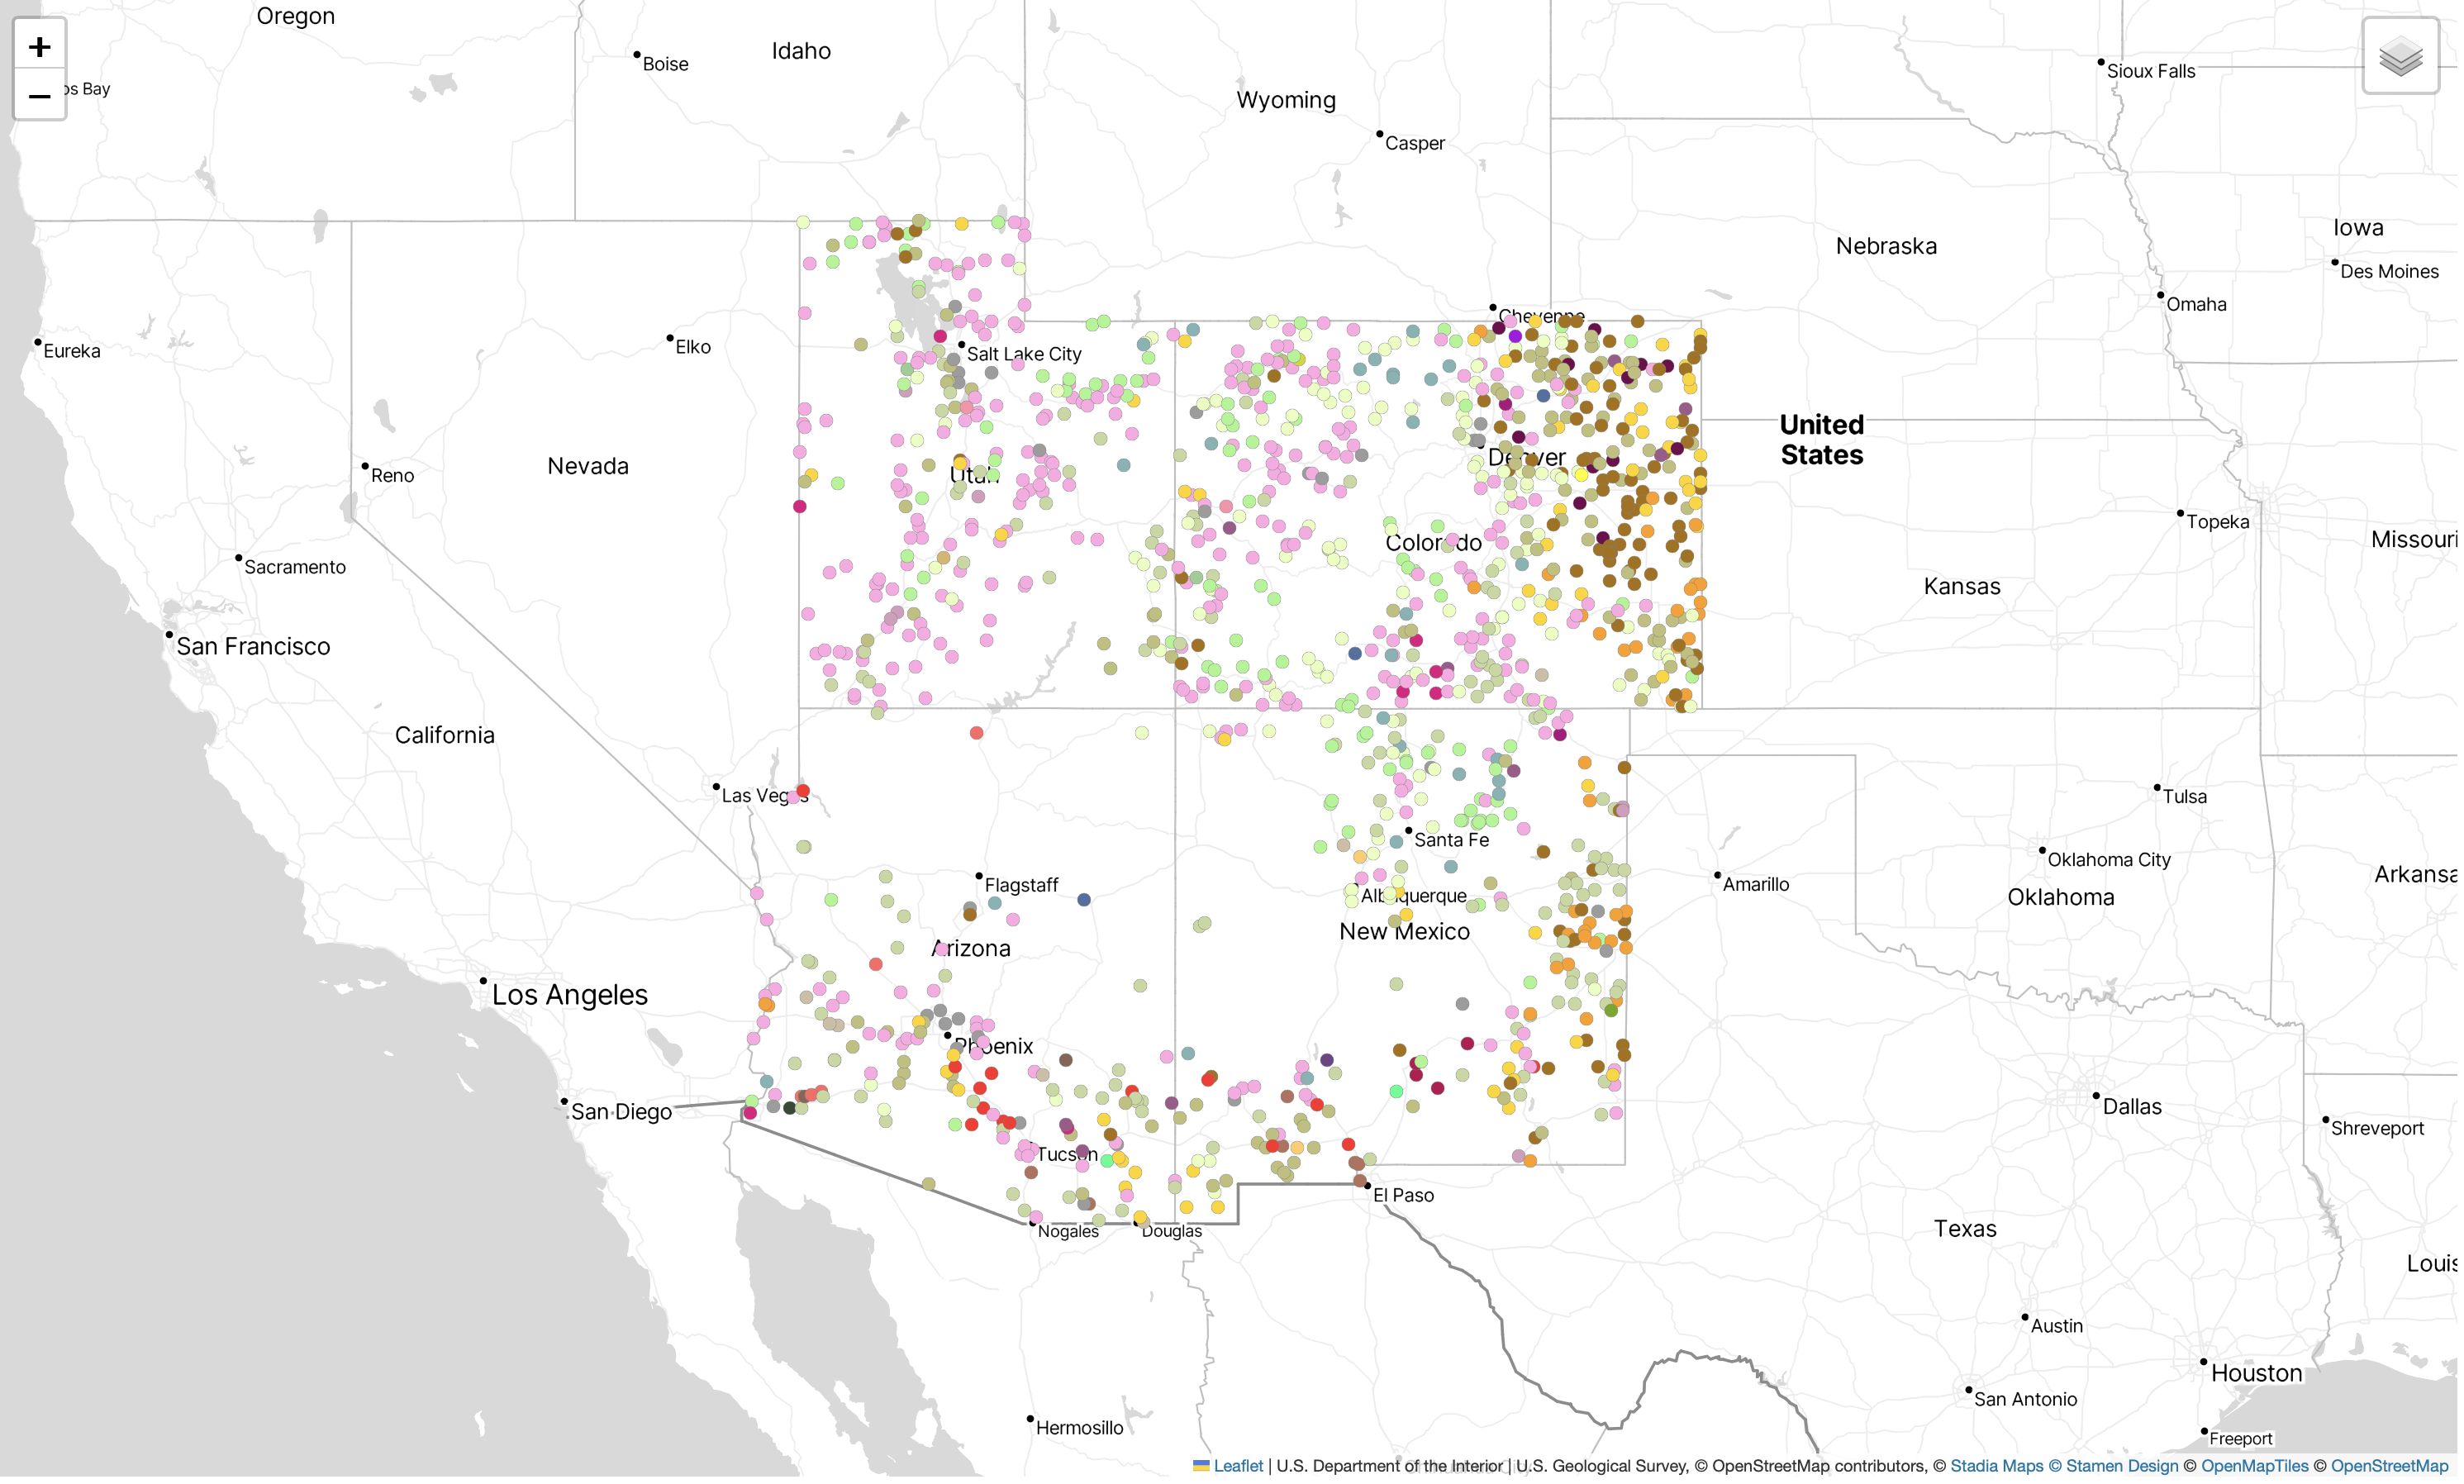 -->

## load ecocrop data

Imputed, includes USDA Hardiness Zones

In [11]:
ecocrop_file = '../data/crops/EcoCrop_Complete.pickle'
ecocrop_all = pd.read_pickle(ecocrop_file)
ecocrop_all

Crop_Code            Scientific_Name         Genus         Species  \
0           289     Abelmoschus esculentus   Abelmoschus      esculentus   
1           290        Abelmoschus manihot   Abelmoschus         manihot   
2           291      Abelmoschus moschatus   Abelmoschus       moschatus   
3           295      Acacia auriculiformis        Acacia  auriculiformis   
4           297          Acacia farnesiana        Acacia      farnesiana   
...         ...                        ...           ...             ...   
2563     400000  Chamaecrista rotundifolia  Chamaecrista    rotundifolia   
2564     400001         Acacia polyacantha        Acacia     polyacantha   
2565     400002           Prosopis affinis      Prosopis         affinis   
2566     400003            Vicia dasycarpa         Vicia       dasycarpa   
2567     400004            Camelina sativa      Camelina          sativa   

     Variety        Life_Form                            Habit  \
0        NaN             herb                            erect   
1        NaN            shrub                            erect   
2        NaN  herb, sub-shrub  prostrate/procumbent/semi-erect   
3        NaN             tree                            erect   
4        NaN             tree                            erect   
...      ...              ...                              ...   
2563     NaN             herb  prostrate/procumbent/semi-erect   
2564     NaN      shrub, tree                            erect   
2565     NaN             tree                            erect   
2566     NaN             herb        climber/scrambler/scadent   
2567     NaN             herb                            erect   

                        Life_Span                                 Physiology  \
0                          annual                                single stem   
1               annual, perennial                      deciduous, multi stem   
2     annual, biennial, perennial                      deciduous, multi stem   
3                       perennial                                single stem   
4                       perennial                                single stem   
...                           ...                                        ...   
2563            annual, perennial                      deciduous, multi stem   
2564                    perennial                    single stem, multi stem   
2565                    perennial  deciduous, single stem, C3 photosynthesis   
2566                       annual                                 multi stem   
2567                       annual                                 multi stem   

                                               Category  ... Crop_Cycle_Max  \
0                                            vegetables  ...          180.0   
1     vegetables, ornamentals/turf, medicinals & aro...  ...          365.0   
2               ornamentals/turf, medicinals & aromatic  ...            0.0   
3                                           forest/wood  ...          240.0   
4     materials, ornamentals/turf, medicinals & arom...  ...          240.0   
...                                                 ...  ...            ...   
2563              forage/pasture, medicinals & aromatic  ...            0.0   
2564                         forest/wood, environmental  ...            0.0   
2565                                        forest/wood  ...            0.0   
2566                                     forage/pasture  ...            0.0   
2567                                     forage/pasture  ...            0.0   

                Use_Main     Use_Detailed      Use_Part  \
0        food & beverage         vitamins        fruits   
1        food & beverage         vitamins        leaves   
2          environmental  ornamental/turf  entire plant   
3               material       dye/tannin         stems   
4          environmental  ornamental/turf  entire plant   
...                  ...            

In [12]:
list(ecocrop_all.columns)

['Crop_Code',
 'Scientific_Name',
 'Genus',
 'Species',
 'Variety',
 'Life_Form',
 'Habit',
 'Life_Span',
 'Physiology',
 'Category',
 'Plant_Attributes',
 'Temp_Opt_Min',
 'Temp_Opt_Max',
 'Temp_Opt_Min_F',
 'Temp_Opt_Max_F',
 'Temp_Abs_Min',
 'Temp_Abs_Max',
 'Temp_Abs_Min_F',
 'Temp_Abs_Max_F',
 'Killing_Temp_Rest',
 'Killing_Temp_Growth',
 'Killing_Temp_Rest_F',
 'Killing_Temp_Growth_F',
 'Rain_Opt_Min',
 'Rain_Opt_Max',
 'Rain_Abs_Min',
 'Rain_Abs_Max',
 'Lat_Opt_Min',
 'Lat_Opt_Max',
 'Lat_Abs_Min',
 'Lat_Abs_Max',
 'Alt_Opt_Min',
 'Alt_Opt_Max',
 'Alt_Abs_Min',
 'Alt_Abs_Max',
 'pH_Opt_Min',
 'pH_Opt_Max',
 'pH_Abs_Min',
 'pH_Abs_Max',
 'Light_Opt_Min',
 'Light_Opt_Max',
 'Light_Abs_Min',
 'Light_Abs_Max',
 'Depth_Opt',
 'Depth_Abs',
 'Texture_Ops',
 'Texture_Abs',
 'Fertility_Ops',
 'Fertility_Abs',
 'Al_Toxicity_Opt',
 'Al_Toxicity_Abs',
 'Salinity_Ops',
 'Salinity_Abs',
 'Drainage_Opt',
 'Drainage_Abs',
 'Photoperiod',
 'Abiotic_Tolererance',
 'Abiotic_Susceptibility',
 'Intr

In [13]:
crop_columns = [
    'Crop_Code',
    'Scientific_Name',
    'Genus',
    'Species',
    'Variety',
    # 'Life_Form',
    # 'Habit',
    'Life_Span',
    # 'Physiology',
    # 'Category',
    # 'Plant_Attributes',
    # 'Temp_Opt_Min',
    # 'Temp_Opt_Max',
    'Temp_Opt_Min_F',
    'Temp_Opt_Max_F',
    # 'Temp_Abs_Min',
    # 'Temp_Abs_Max',
    'Temp_Abs_Min_F',
    'Temp_Abs_Max_F',
    # 'Killing_Temp_Rest',
    # 'Killing_Temp_Growth',
    'Killing_Temp_Rest_F',
    'Killing_Temp_Growth_F',
    # 'Rain_Opt_Min',
    # 'Rain_Opt_Max',
    # 'Rain_Abs_Min',
    # 'Rain_Abs_Max',
    # 'Lat_Opt_Min',
    # 'Lat_Opt_Max',
    # 'Lat_Abs_Min',
    # 'Lat_Abs_Max',
    # 'Alt_Opt_Min',
    # 'Alt_Opt_Max',
    # 'Alt_Abs_Min',
    # 'Alt_Abs_Max',
    # 'pH_Opt_Min',
    # 'pH_Opt_Max',
    # 'pH_Abs_Min',
    # 'pH_Abs_Max',
    # 'Light_Opt_Min',
    # 'Light_Opt_Max',
    # 'Light_Abs_Min',
    # 'Light_Abs_Max',
    # 'Depth_Opt',
    # 'Depth_Abs',
    # 'Texture_Ops',
    # 'Texture_Abs',
    # 'Fertility_Ops',
    # 'Fertility_Abs',
    # 'Al_Toxicity_Opt',
    # 'Al_Toxicity_Abs',
    # 'Salinity_Ops',
    # 'Salinity_Abs',
    # 'Drainage_Opt',
    # 'Drainage_Abs',
    # 'Photoperiod',
    # 'Abiotic_Tolererance',
    # 'Abiotic_Susceptibility',
    # 'Introduction_Risks',
    # 'Production_System',
    # 'Cropping_System',
    # 'Subsystem',
    # 'Companion_Species',
    # 'Level_of_Mechanization',
    # 'Labour_Intensity',
    'Crop_Cycle_Min',
    'Crop_Cycle_Max',
    # 'Use_Main',
    # 'Use_Detailed',
    # 'Use_Part',
    # 'Climate_Zone_Trewartha',
    # 'USDA_Hardiness_Zone',
    # 'USDA_Hardiness_Zone_Min',
    # 'USDA_Hardiness_Zone_Max',
    # 'Datasheet_URL',
    # 'PFAF_URL'
]

In [14]:
crop_data = ecocrop_all[crop_columns]
crop_data

Crop_Code            Scientific_Name         Genus         Species  \
0           289     Abelmoschus esculentus   Abelmoschus      esculentus   
1           290        Abelmoschus manihot   Abelmoschus         manihot   
2           291      Abelmoschus moschatus   Abelmoschus       moschatus   
3           295      Acacia auriculiformis        Acacia  auriculiformis   
4           297          Acacia farnesiana        Acacia      farnesiana   
...         ...                        ...           ...             ...   
2563     400000  Chamaecrista rotundifolia  Chamaecrista    rotundifolia   
2564     400001         Acacia polyacantha        Acacia     polyacantha   
2565     400002           Prosopis affinis      Prosopis         affinis   
2566     400003            Vicia dasycarpa         Vicia       dasycarpa   
2567     400004            Camelina sativa      Camelina          sativa   

     Variety                    Life_Span  Temp_Opt_Min_F  Temp_Opt_Max_F  \
0        NaN                       annual       68.000000       86.000000   
1        NaN            annual, perennial       71.600000       86.000000   
2        NaN  annual, biennial, perennial       68.000000       86.000000   
3        NaN                    perennial       75.200000       89.600000   
4        NaN                    perennial       68.000000       89.600000   
...      ...                          ...             ...             ...   
2563     NaN            annual, perennial       68.000000       77.000000   
2564     NaN                    perennial       68.293478       90.010870   
2565     NaN                    perennial       69.800000       88.880000   
2566     NaN                       annual       55.400000       72.745455   
2567     NaN                       annual       67.447791       86.090697   

      Temp_Abs_Min_F  Temp_Abs_Max_F  Killing_Temp_Rest_F  \
0          53.600000       95.000000            18.815544   
1          60.800000       96.800000            18.815544   
2          50.000000       95.000000            18.815544   
3          50.000000      104.000000            18.815544   
4          44.600000      107.600000            18.815544   
...              ...             ...                  ...   
2563       59.000000       86.000000            18.815544   
2564       48.943478      104.860870            18.815544   
2565       53.960000      104.000000            18.815544   
2566       41.327273       83.709091            18.815544   
2567       50.588950       98.953343            18.815544   

      Killing_Temp_Growth_F  Crop_Cycle_Min  Crop_Cycle_Max  
0                 31.243005            50.0           180.0  
1                 31.243005           365.0           365.0  
2                 31.243005             0.0             0.0  
3                 31.243005           180.0           240.0  
4                 31.243005            60.0           240.0  
...                     ...             ...             ...  
2563              31.243005             0.0             0.0  
2564              31.243005             0.0             0.0  
2565              31.243005             0.0             0.0  
2566              31.243005             0.0             0.0  
2567              31.243005             0.0             0.0  

[2568 rows x 14 columns]

In [15]:
list(crop_data['Variety'].unique())[:10]

[nan,
 'dulce',
 'cepa',
 'botrytis',
 'capitata',
 'gemmifera',
 'italica',
 'aggregatum',
 'piperascens',
 'flavicarpa']

In [16]:
len(list(crop_data['Variety'].unique()))

72

In [17]:
np.sort(crop_data['Temp_Opt_Min_F'].unique())

array([ 41.        ,  42.8       ,  44.6       ,  45.5       ,
        46.4       ,  48.2       ,  49.28      ,  50.        ,
        51.8       ,  52.88      ,  53.08571429,  53.15      ,
        53.6       ,  54.68      ,  54.8       ,  55.4       ,
        56.3       ,  56.75      ,  56.87272727,  57.2       ,
        57.4       ,  57.8       ,  58.1       ,  58.28      ,
        58.55      ,  59.        ,  59.6       ,  59.9       ,
        60.26      ,  60.35      ,  60.8       ,  61.4       ,
        62.6       ,  63.09090909,  63.8       ,  64.01428571,
        64.4       ,  65.        ,  65.3       ,  65.6       ,
        66.2       ,  66.38      ,  66.6       ,  67.1       ,
        67.4477909 ,  67.48571429,  67.64      ,  67.7       ,
        68.        ,  68.25714286,  68.29347826,  68.4       ,
        68.6       ,  68.9       ,  69.28571429,  69.8       ,
        70.25      ,  70.4       ,  70.7       ,  70.85      ,
        71.15      ,  71.6       ,  72.5       ,  72.68

In [18]:
np.sort(crop_data['Temp_Opt_Max_F'].unique())

array([ 57.2       ,  59.        ,  60.8       ,  62.6       ,
        64.4       ,  65.12      ,  65.3       ,  66.2       ,
        67.1       ,  67.28      ,  68.        ,  68.25714286,
        69.2       ,  69.35      ,  69.8       ,  70.52      ,
        70.7       ,  71.6       ,  72.05      ,  72.5       ,
        72.63636364,  72.74545455,  72.8       ,  72.95      ,
        73.4       ,  74.6       ,  75.2       ,  75.92      ,
        76.        ,  76.1       ,  77.        ,  77.9       ,
        78.02857143,  78.35      ,  78.8       ,  79.25      ,
        79.7       ,  80.        ,  80.27272727,  80.6       ,
        80.85714286,  81.5       ,  81.8       ,  81.88571429,
        82.        ,  82.4       ,  82.7       ,  83.        ,
        83.12      ,  83.3       ,  83.6       ,  83.68571429,
        83.84      ,  84.2       ,  84.65      ,  84.8       ,
        84.84285714,  85.1       ,  85.28      ,  85.4       ,
        85.46      ,  86.        ,  86.09069745,  86.9 

In [19]:
np.sort(crop_data['Killing_Temp_Growth_F'].unique())

array([-4.        , 14.        , 15.8       , 17.6       , 21.2       ,
       23.        , 24.8       , 26.6       , 28.4       , 30.2       ,
       31.24300518, 32.        , 33.8       , 35.6       , 37.4       ,
       39.2       , 41.        , 44.6       , 46.4       , 48.2       ,
       50.        , 53.6       , 57.2       ])

In [20]:
np.sort(crop_data['Killing_Temp_Rest_F'].unique())

array([-58.        , -49.        , -47.2       , -43.6       ,
       -41.8       , -40.        , -38.2       , -36.4       ,
       -31.        , -29.2       , -27.4       , -25.6       ,
       -22.        , -20.2       , -18.4       , -16.6       ,
       -13.        , -11.2       ,  -9.4       ,  -7.6       ,
        -4.        ,  -0.4       ,   1.4       ,   3.2       ,
         5.        ,   6.8       ,   8.6       ,  10.4       ,
        12.2       ,  14.        ,  15.8       ,  17.6       ,
        18.81554404,  19.4       ,  21.2       ,  23.        ,
        24.8       ,  26.6       ,  28.4       ,  30.2       ,
        33.8       ,  35.6       ,  37.4       ,  39.2       ,
        41.        ,  44.6       ,  46.4       ,  48.2       ,
        50.        ,  57.2       ])

In [21]:
np.sort(crop_data['Crop_Cycle_Min'].unique())

array([  0.        ,  10.        ,  21.        ,  30.        ,
        35.        ,  40.        ,  42.        ,  45.        ,
        50.        ,  55.        ,  60.        ,  65.        ,
        70.        ,  75.        ,  80.        ,  85.        ,
        90.        ,  95.        , 100.        , 105.        ,
       110.        , 120.        , 125.        , 127.15777172,
       130.        , 135.        , 140.        , 150.        ,
       160.        , 170.        , 175.        , 180.        ,
       190.        , 200.        , 210.        , 215.        ,
       220.        , 240.        , 250.        , 260.        ,
       270.        , 280.        , 300.        , 330.        ,
       365.        ])

In [22]:
np.sort(crop_data['Crop_Cycle_Max'].unique())

array([  0.        ,  45.        ,  55.        ,  60.        ,
        70.        ,  80.        ,  85.        ,  90.        ,
        95.        , 100.        , 105.        , 110.        ,
       115.        , 120.        , 125.        , 130.        ,
       135.        , 140.        , 150.        , 160.        ,
       165.        , 170.        , 175.        , 176.        ,
       180.        , 190.        , 192.29216985, 195.        ,
       200.        , 210.        , 215.        , 220.        ,
       229.        , 230.        , 240.        , 245.        ,
       249.        , 250.        , 255.        , 260.        ,
       270.        , 280.        , 300.        , 305.        ,
       320.        , 325.        , 330.        , 340.        ,
       350.        , 365.        ])

In [23]:
np.sort(crop_data['Life_Span'].unique())

array(['annual', 'annual, biennial', 'annual, biennial, perennial',
       'annual, perennial', 'biennial', 'biennial, perennial',
       'perennial'], dtype=object)

## look up temperature data

In [24]:
geo_balanced_csb_samples.crs

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.7/projjso ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
# Load one of the NetCDF files to inspect it
file_path = '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-historical_w1976-2005.nc'
ds = xr.open_dataset(file_path)

# Print the dataset to inspect its variables
print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:             (time: 1, lat: 490, lon: 960)
Coordinates:
  * lat                 (lat) float64 4kB 23.41 23.47 23.53 ... 53.91 53.97
  * lon                 (lon) float64 8kB 234.0 234.1 234.2 ... 293.9 294.0
  * time                (time) datetime64[ns] 8B 1990-01-01T00:01:00
Data variables:
    growing_season_41F  (time, lat, lon) float32 2MB ...
Attributes:
    Conventions:  CF-1.7
    title:        


In [26]:
# Print the global attributes of the dataset
print(ds.data_vars)
# print(ds.coordinate_system)
print(list(ds.coords))

# Print the attributes of the lat and lon variables
print(ds['lat'].attrs)
print(ds['lon'].attrs)

Data variables:
    growing_season_41F  (time, lat, lon) float32 2MB ...
['lat', 'lon', 'time']
{'standard_name': 'latitude', 'long_name': 'latitude', 'units': 'degrees_north', 'axis': 'Y'}
{'standard_name': 'longitude', 'long_name': 'longitude', 'units': 'degrees_east', 'axis': 'X'}


In [27]:
# Load one of the NetCDF files to inspect it
file_path = '../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc'
ds = xr.open_dataset(file_path)

# Print the dataset to inspect its variables
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:          (lat: 585, lon: 1386, crs: 1)
Coordinates:
  * lat              (lat) float64 5kB 25.07 25.11 25.15 ... 49.32 49.36 49.4
  * lon              (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.1 -67.06
  * crs              (crs) int32 4B 1
Data variables:
    air_temperature  (lat, lon) float32 3MB ...
Attributes: (12/50)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   GRID
    ...                              ...
    geospatial_lon_min:              -124.7666666333333
    geospatial_lon_max:              -67.058333300000015
    geospatial_lon_resolution:       0.041666666666666
    geospatial_lat_resolution:       0.041666666666666
    NCO:                       

In [28]:
# Print the global attributes of the dataset
print(ds.attrs)

# Print the attributes of the lat and lon variables
print(ds['lat'].attrs)
print(ds['lon'].attrs)

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.', 'id': 'MACAv2-METDATA', 'naming_authority': 'edu.uidaho.reacch', 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0', 'Metadata_Link': '', 'cdm_data_type': 'GRID', 'title': 'Downscaled daily meteorological data of Daily Mean Near-Surface Air Temperature from Average (20CMIP5ModelMean) using the run r1i1p1 of the historical scenario.', 'summary': 'This archive contains daily downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution utilizing the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological variables are maximum/minimum temperature(tasmax/tasmin), maximum/minimum relative humidity (rhsmax/rhsmin)precipitation amount(pr), downward shortwave solar radiation(rsds), eastward wind(uas), northward wind(va

In [29]:
# Print the global attributes of the dataset
print(list(ds.data_vars))
print(ds.coordinate_system)
print(list(ds.coords))
print(ds.dims)

# Print the attributes of the lat and lon variables
print(ds['lat'].attrs)
print(ds['lon'].attrs)

['air_temperature']
EPSG:4326
['lat', 'lon', 'crs']
FrozenMappingWarningOnValuesAccess({'lat': 585, 'lon': 1386, 'crs': 1})
{'long_name': 'latitude', 'standard_name': 'latitude', 'axis': 'Y', 'units': 'degrees_north', 'description': 'latitude', 'grid_mapping': 'crs'}
{'long_name': 'longitude', 'standard_name': 'longitude', 'axis': 'X', 'units': 'degrees_east', 'description': 'longitude', 'grid_mapping': 'crs'}


In [30]:
# https://scenarios.globalchange.gov/loca-viewer/

loca_data_folder = '../datasets/climate/NCA4_LOCA_data_all/'

growing_season_filenames = [

    # Growing Season 41F - Length of the growing season, 41°F threshold (the number of days between 
    # the last occurrence of a minimum temperature at or below 41°F in the spring and
    # the first occurrence of a minimum temperature at or below 41°F in the fall)
    'growing-season-41F-historical_w1976-2005.nc',
    'growing-season-41F-rcp45_w2036-2065.nc',
    'growing-season-41F-rcp85_w2036-2065.nc',
    # need these to approximate when during the year the growing season occurs
    # 'first-freeze-date-historical_w1976-2005.nc',
    # 'first-freeze-date-rcp45_W2036-2065.nc',
    # 'first-freeze-date-rcp85_W2036-2065.nc',
    # 'last-freeze-date-historical_w1976-2005.nc',
    # 'last-freeze-date-rcp45_w2036-2065.nc',
    # 'last-freeze-date-rcp85_w2036-2065.nc',
    ]

# don't use these because degree-days are difficult to match to the EcoCrop data

# # Cooling Degree Days - Cooling degree days (annual cumulative number of degrees by which the daily average temperature is greater than 65°F) [degree days (degF)]
# 'cdd-historical_w1976-2005.nc',
# 'cdd-rcp45_w2036-2065.nc',
# 'cdd-rcp85_w2036-2065.nc',

# # Growing Degree Days - Growing degree days, base 50 (annual cumulative number of degrees by which the daily average temperature is greater than 50°F) [degree days (degF)]
# 'gdd-historical_w1976-2005.nc',
# 'gdd-rcp45_w2036-2065.nc',
# 'gdd-rcp85_w2036-2065.nc',
    
# don't need these because Temp_Opt_Min_F >41 for all crops

# # growing-season - Length of the growing (frost-free) season (the number of days between 
# # the last occurrence of a minimum temperature at or below 32degF in the spring and 
# # the first occurrence of a minimum temperature at or below 32degF in the fall)
# 'growing-season-historical_w1976-2005.nc'
# 'growing-season-rcp45_w2036-2065.nc'
# 'growing-season-rcp85_w2036-2065.nc'

# # Growing Season 28F - Length of the growing season, 28°F threshold (the number of days between 
# # the last occurrence of a minimum temperature at or below 28°F in the spring and 
# # the first occurrence of a minimum temperature at or below 28°F in the fall)
# 'growing-season-28F-historical_w1976-2005.nc'
# 'growing-season-28F-rcp45_w2036-2065.nc'
# 'growing-season-28F-rcp85_w2036-2065.nc'

# growing_season_filenames

In [31]:
! ls '../data/climate/ClimateToolbox/'

mean_summer_temperature_1970_2000_historical.nc
mean_summer_temperature_2040_2069_rcp45.nc
mean_summer_temperature_2040_2069_rcp85.nc
minimum_annual_temperature_1970_2000_historical.nc
minimum_annual_temperature_2040_2069_rcp45.nc
minimum_annual_temperature_2040_2069_rcp85.nc
minimum_summer_temperature_1970_2000_historical.nc
minimum_summer_temperature_2040_2069_rcp45.nc
minimum_summer_temperature_2040_2069_rcp85.nc
precipitation_total_1971_2000_historical_JJA.nc
precipitation_total_1971_2000_historical_MAM.nc
precipitation_total_2040_2069_rcp45_JJA.nc
precipitation_total_2040_2069_rcp45_MAM.nc
precipitation_total_2040_2069_rcp85_JJA.nc
precipitation_total_2040_2069_rcp85_MAM.nc


In [32]:
climate_toolbox_data_folder = '../data/climate/ClimateToolbox/'

temperature_filenames = [
'mean_summer_temperature_1970_2000_historical.nc',
'mean_summer_temperature_2040_2069_rcp45.nc',
'mean_summer_temperature_2040_2069_rcp85.nc',
'minimum_annual_temperature_1970_2000_historical.nc',
'minimum_annual_temperature_2040_2069_rcp45.nc',
'minimum_annual_temperature_2040_2069_rcp85.nc',
'minimum_summer_temperature_1970_2000_historical.nc',
'minimum_summer_temperature_2040_2069_rcp45.nc',
'minimum_summer_temperature_2040_2069_rcp85.nc',
]

In [33]:
# geo_balanced_csb_samples['growing-season-41F-historical_w1976-2005'].unique()

In [34]:
# Convert to GeoDataFrame with NAD83 CRS
gdf = gpd.GeoDataFrame(
    geo_balanced_csb_samples,
    geometry=gpd.points_from_xy(geo_balanced_csb_samples.Longitude, geo_balanced_csb_samples.Latitude),
    crs='EPSG:4269'  # NAD83
)

latitudes = gdf['Latitude']
longitudes = gdf['Longitude']

In [35]:
# Adjust longitudes to match NetCDF file's 0-360 range if necessary
# longitudes = (longitudes + 360) % 360

In [36]:
! ls -lga {loca_data_folder}

total 5429840
drwx------@ 521 staff     16672 Aug  7 17:50 .
drwxr-xr-x    4 staff       128 Aug 20 18:18 ..
-rw-rw-r--@   1 staff      6323 Sep  8  2020 LOCA_variablelist.txt
-rw-rw-r--@   1 staff      4834 Sep  8  2020 README.txt
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-historical_w1976-2005.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp45_w2016-2045.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp45_w2036-2065.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp45_w2070-2099.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp85_w2016-2045.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp85_w2036-2065.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-rcp85_w2070-2099.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-top3_w2016-2045.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-top3_w2036-2065.nc
-rw-rw-r--@   1 staff   1964923 Mar  7  2019 cdd-top3_w2070-2099.nc
-rw-rw-rw-@   1 staff  44061625 Aug 19  2019 cdd.csv
-rw-rw-r--@   1 staff  

In [37]:
# Generate dictionary with keys from filenames without extensions
growing_season_files = {os.path.splitext(filename)[0]: f'{loca_data_folder}{filename}' for filename in growing_season_filenames}
growing_season_files

{'growing-season-41F-historical_w1976-2005': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-historical_w1976-2005.nc',
 'growing-season-41F-rcp45_w2036-2065': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp45_w2036-2065.nc',
 'growing-season-41F-rcp85_w2036-2065': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp85_w2036-2065.nc'}

In [38]:
# [filename for filename in temperature_filenames]
# temperature_filenames

In [39]:
temperature_files = {os.path.splitext(filename)[0]: f'{climate_toolbox_data_folder}{filename}' for filename in temperature_filenames}
temperature_files#.keys()

{'mean_summer_temperature_1970_2000_historical': '../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc',
 'mean_summer_temperature_2040_2069_rcp45': '../data/climate/ClimateToolbox/mean_summer_temperature_2040_2069_rcp45.nc',
 'mean_summer_temperature_2040_2069_rcp85': '../data/climate/ClimateToolbox/mean_summer_temperature_2040_2069_rcp85.nc',
 'minimum_annual_temperature_1970_2000_historical': '../data/climate/ClimateToolbox/minimum_annual_temperature_1970_2000_historical.nc',
 'minimum_annual_temperature_2040_2069_rcp45': '../data/climate/ClimateToolbox/minimum_annual_temperature_2040_2069_rcp45.nc',
 'minimum_annual_temperature_2040_2069_rcp85': '../data/climate/ClimateToolbox/minimum_annual_temperature_2040_2069_rcp85.nc',
 'minimum_summer_temperature_1970_2000_historical': '../data/climate/ClimateToolbox/minimum_summer_temperature_1970_2000_historical.nc',
 'minimum_summer_temperature_2040_2069_rcp45': '../data/climate/ClimateToolbox/minimum_summer_tempe

In [40]:
combined_files = growing_season_files | temperature_files

In [41]:
combined_files

{'growing-season-41F-historical_w1976-2005': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-historical_w1976-2005.nc',
 'growing-season-41F-rcp45_w2036-2065': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp45_w2036-2065.nc',
 'growing-season-41F-rcp85_w2036-2065': '../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp85_w2036-2065.nc',
 'mean_summer_temperature_1970_2000_historical': '../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc',
 'mean_summer_temperature_2040_2069_rcp45': '../data/climate/ClimateToolbox/mean_summer_temperature_2040_2069_rcp45.nc',
 'mean_summer_temperature_2040_2069_rcp85': '../data/climate/ClimateToolbox/mean_summer_temperature_2040_2069_rcp85.nc',
 'minimum_annual_temperature_1970_2000_historical': '../data/climate/ClimateToolbox/minimum_annual_temperature_1970_2000_historical.nc',
 'minimum_annual_temperature_2040_2069_rcp45': '../data/climate/ClimateToolbox/minimum_annual_temperature_2040_2069_r

In [42]:

# Function to extract data variable names from a NetCDF file
def extract_data_variables(file_path):
    ds = xr.open_dataset(file_path)
    print(list(ds.data_vars))
    return list(ds.data_vars)

# Function to generate a column name from the scenario name using regex
def extract_column_name(scenario_name):
    match = re.match(r'^(.*?)-(historical|rcp45|rcp85)_w(\d{4}-\d{4})', scenario_name)
    if match:
        column_name = f"{match.group(1).replace('-', '_')}_w{match.group(3).replace('-', '_')}_{match.group(2)}"
    else:
        column_name = scenario_name.replace('-', '_')
    return column_name

# # Function to extract variable name from the filename using regex
# def extract_variable_name(file_path):
#     # Open the dataset to inspect its variables
#     ds = xr.open_dataset(file_path)
#     # Assuming there's only one variable of interest, take the first one
#     variable_name = list(ds.data_vars)[0]
#     return variable_name


# Function to get climate values for specific locations
def get_climate_values_for_locations(latitudes, longitudes, file_path):
    ds = xr.open_dataset(file_path)

    variable_name = list(ds.data_vars)[0]
    print(f"Variable name: {variable_name}")

    # Check if the dataset has a time dimension and select the first time slice if present
    if 'time' in ds.dims:
        ds = ds.isel(time=0)

    # Ensure the variable name exists in the dataset
    if variable_name not in ds.data_vars:
        raise ValueError(f"Variable {variable_name} does not exist in the dataset.")

    # Check if longitudes in the dataset are in the range [0, 360]
    lon_min = ds.lon.min().values
    lon_max = ds.lon.max().values

    if lon_max > 180:
        # Adjust input longitudes to match the NetCDF file's 0-360 range
        longitudes = (longitudes + 360) % 360

    # Create a DataArray for the interpolation points
    points = xr.DataArray(
        np.array([latitudes, longitudes]).T,
        dims=["points", "coords"],
        coords={"points": range(len(latitudes)), "coords": ["lat", "lon"]}
    )

    # Interpolate the data
    climate_values = ds[variable_name].interp(lat=points[:, 0], lon=points[:, 1], method='linear')
    print(climate_values.values[:10])
    # Return the interpolated values for the specified variable
    return climate_values.values


In [43]:
# Time the step of adding growing season data to the dataframe
start_time = time.time()
for scenario_name, file_path in combined_files.items():
    print(file_path)
    # Extract column name from the scenario name
    column_name = extract_column_name(scenario_name)
    print(f"Column name: {column_name}")
    
    # # Extract variable name from the file
    # variable_name = extract_variable_name(file_path)
    # print(f"Variable name: {variable_name}")
    
    if column_name:
        interpolated_values = get_climate_values_for_locations(
            latitudes,
            longitudes,
            file_path,
            # variable_name
        )
        # Ensure the length of interpolated values matches the DataFrame's index length
        if len(interpolated_values) == len(gdf):
            # print(interpolated_values[:10])
            gdf[column_name] = interpolated_values
        else:
            raise ValueError(f"Length of interpolated values ({len(interpolated_values)}) does not match the length of the DataFrame's index ({len(gdf)})")

end_time = time.time()

# Print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-historical_w1976-2005.nc
Column name: growing_season_41F_w1976_2005_historical
Variable name: growing_season_41F
[113.98070302 158.66689696 104.24687228  20.86597957  93.98441851
 101.68068372 118.8745688   34.81104367  68.52306322  90.84498917]
../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp45_w2036-2065.nc
Column name: growing_season_41F_w2036_2065_rcp45
Variable name: growing_season_41F
[15.66329483 19.16534107 23.06250898 29.46111054 19.14119503 16.6112148
 21.20497771 28.12626912 26.91568673 24.97673647]
../datasets/climate/NCA4_LOCA_data_all/growing-season-41F-rcp85_w2036-2065.nc
Column name: growing_season_41F_w2036_2065_rcp85
Variable name: growing_season_41F
[19.59885864 25.43586222 28.99056457 38.31578281 22.55407023 19.90548551
 27.70525553 38.01524268 33.31069211 31.31677479]
../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc
Column name: mean_summer_temperature_1970_2000_his

In [44]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1200 entries, 478801 to 308295
Data columns (total 38 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   CSBID                                            1200 non-null   object  
 1   CSBYEARS                                         1200 non-null   object  
 2   CSBACRES                                         1200 non-null   float64 
 3   CDL2016                                          1200 non-null   int64   
 4   CDL2017                                          1200 non-null   int64   
 5   CDL2018                                          1200 non-null   int64   
 6   CDL2019                                          1200 non-null   int64   
 7   CDL2020                                          1200 non-null   int64   
 8   CDL2021                                          1200 non-null   int64   
 9   CDL2022  

In [45]:
# ds = xr.open_dataset('../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc')
# variable_name = list(ds.data_vars)[0]
# variable_name

In [46]:
# points = xr.DataArray(
#     np.array([latitudes, longitudes]).T,
#     dims=["points", "coords"],
#     coords={"points": range(len(latitudes)), "coords": ["lat", "lon"]}
# )

In [47]:
# climate_values = ds[variable_name].interp(lat=points[:, 0], lon=points[:, 1], method='linear')
# climate_values

## troubleshooting ClimateToolbox .nc files

In [48]:
# import xarray as xr
# import numpy as np

# # # Example latitude and longitude arrays
# # latitudes = [34.05, 36.16, 40.71]  # Example latitudes
# # longitudes = [-118.25, -115.15, -74.01]  # Example longitudes

# # Load the dataset
# file_path = '../data/climate/ClimateToolbox/mean_summer_temperature_1970_2000_historical.nc'
# ds = xr.open_dataset(file_path)

# # Print the dataset to inspect its variables and coordinates
# print(ds)

# # Extract the first data variable name
# variable_name = list(ds.data_vars)[0]
# print(f"Variable name: {variable_name}")

# # Check the bounds of the dataset's coordinates
# lat_min = ds.lat.min().values
# lat_max = ds.lat.max().values
# lon_min = ds.lon.min().values
# lon_max = ds.lon.max().values
# print(f"Latitude bounds: {lat_min}, {lat_max}")
# print(f"Longitude bounds: {lon_min}, {lon_max}")

# # Ensure the requested points are within the dataset's coordinate bounds
# for lat, lon in zip(latitudes, longitudes):
#     if not (lat_min <= lat <= lat_max):
#         raise ValueError(f"Latitude {lat} is out of bounds ({lat_min}, {lat_max})")
#     if not (lon_min <= lon <= lon_max):
#         raise ValueError(f"Longitude {lon} is out of bounds ({lon_min}, {lon_max})")

# # Create a DataArray for the interpolation points
# points = xr.DataArray(
#     np.array([latitudes, longitudes]).T,
#     dims=["points", "coords"],
#     coords={"points": range(len(latitudes)), "coords": ["lat", "lon"]}
# )

# # Interpolate the data
# climate_values = ds[variable_name].interp(lat=points[:, 0], lon=points[:, 1], method='linear')

# # Check for NaN values in the interpolated results
# if np.isnan(climate_values).any():
#     print("Warning: Interpolated values contain NaNs")

# # Print the interpolated values for debugging
# print("Interpolated climate values:")
# print(climate_values.values)

In [49]:
# gdf

In [50]:
# # replace change with number of days from 1 January

# gdf['growing_season_41F_rcp45_w2036_2065'] = gdf['growing_season_41F_historical_w1976_2005'] + gdf['growing_season_41F_rcp45_w2036_2065']
# gdf['growing_season_41F_rcp85_w2036_2065'] = gdf['growing_season_41F_historical_w1976_2005'] + gdf['growing_season_41F_rcp85_w2036_2065']

# gdf['first_freeze_date_rcp45_W2036_2065' ] = gdf['first_freeze_date_historical_w1976_2005' ] + gdf['first_freeze_date_rcp45_W2036_2065' ]
# gdf['first_freeze_date_rcp85_W2036_2065' ] = gdf['first_freeze_date_historical_w1976_2005' ] + gdf['first_freeze_date_rcp85_W2036_2065' ]

# gdf['last_freeze_date_rcp45_w2036_2065'  ] = gdf['last_freeze_date_historical_w1976_2005'  ] + gdf['last_freeze_date_rcp45_w2036_2065'  ]
# gdf['last_freeze_date_rcp85_w2036_2065'  ] = gdf['last_freeze_date_historical_w1976_2005'  ] + gdf['last_freeze_date_rcp85_w2036_2065'  ]

In [51]:
gdf.columns

Index(['CSBID', 'CSBYEARS', 'CSBACRES', 'CDL2016', 'CDL2017', 'CDL2018',
       'CDL2019', 'CDL2020', 'CDL2021', 'CDL2022', 'CDL2023', 'STATEFIPS',
       'STATEASD', 'ASD', 'CNTY', 'CNTYFIPS', 'INSIDE_X', 'INSIDE_Y',
       'Shp_Len', 'Shp_Area', 'geometry', 'Longitude', 'Latitude', 'Elevation',
       'color', 'Crop', 'growing_season_41F_w1976_2005_historical',
       'growing_season_41F_w2036_2065_rcp45',
       'growing_season_41F_w2036_2065_rcp85',
       'mean_summer_temperature_1970_2000_historical',
       'mean_summer_temperature_2040_2069_rcp45',
       'mean_summer_temperature_2040_2069_rcp85',
       'minimum_annual_temperature_1970_2000_historical',
       'minimum_annual_temperature_2040_2069_rcp45',
       'minimum_annual_temperature_2040_2069_rcp85',
       'minimum_summer_temperature_1970_2000_historical',
       'minimum_summer_temperature_2040_2069_rcp45',
       'minimum_summer_temperature_2040_2069_rcp85'],
      dtype='object')

In [52]:
columns_to_check = [
    'growing_season_41F_w1976_2005_historical',
    'growing_season_41F_w2036_2065_rcp45',
    'growing_season_41F_w2036_2065_rcp85',
    'mean_summer_temperature_1970_2000_historical',
    'mean_summer_temperature_2040_2069_rcp45',
    'mean_summer_temperature_2040_2069_rcp85',
    'minimum_annual_temperature_1970_2000_historical',
    'minimum_annual_temperature_2040_2069_rcp45',
    'minimum_annual_temperature_2040_2069_rcp85',
    'minimum_summer_temperature_1970_2000_historical',
    'minimum_summer_temperature_2040_2069_rcp45',
    'minimum_summer_temperature_2040_2069_rcp85'
]

for column in columns_to_check:
    print(f'{column:>50} {gdf[column].min():>8.1f} (Min),   {gdf[column].max():>8.1f} (Max)')

          growing_season_41F_w1976_2005_historical      0.2 (Min),      265.6 (Max)
               growing_season_41F_w2036_2065_rcp45      1.8 (Min),       37.7 (Max)
               growing_season_41F_w2036_2065_rcp85      3.9 (Min),       48.7 (Max)
      mean_summer_temperature_1970_2000_historical     47.9 (Min),       94.2 (Max)
           mean_summer_temperature_2040_2069_rcp45     52.8 (Min),       98.7 (Max)
           mean_summer_temperature_2040_2069_rcp85     54.6 (Min),      100.2 (Max)
   minimum_annual_temperature_1970_2000_historical     18.2 (Min),       61.1 (Max)
        minimum_annual_temperature_2040_2069_rcp45     23.0 (Min),       64.9 (Max)
        minimum_annual_temperature_2040_2069_rcp85     24.7 (Min),       66.3 (Max)
   minimum_summer_temperature_1970_2000_historical     35.3 (Min),       80.2 (Max)
        minimum_summer_temperature_2040_2069_rcp45     40.0 (Min),       84.7 (Max)
        minimum_summer_temperature_2040_2069_rcp85     41.6 (Min),       86.

In [53]:
# set dataframe names
csb_field_samples = gdf
field_data = gdf

## temperature score

In [54]:
crop_data.columns

Index(['Crop_Code', 'Scientific_Name', 'Genus', 'Species', 'Variety',
       'Life_Span', 'Temp_Opt_Min_F', 'Temp_Opt_Max_F', 'Temp_Abs_Min_F',
       'Temp_Abs_Max_F', 'Killing_Temp_Rest_F', 'Killing_Temp_Growth_F',
       'Crop_Cycle_Min', 'Crop_Cycle_Max'],
      dtype='object')

In [55]:
csb_field_samples.columns

Index(['CSBID', 'CSBYEARS', 'CSBACRES', 'CDL2016', 'CDL2017', 'CDL2018',
       'CDL2019', 'CDL2020', 'CDL2021', 'CDL2022', 'CDL2023', 'STATEFIPS',
       'STATEASD', 'ASD', 'CNTY', 'CNTYFIPS', 'INSIDE_X', 'INSIDE_Y',
       'Shp_Len', 'Shp_Area', 'geometry', 'Longitude', 'Latitude', 'Elevation',
       'color', 'Crop', 'growing_season_41F_w1976_2005_historical',
       'growing_season_41F_w2036_2065_rcp45',
       'growing_season_41F_w2036_2065_rcp85',
       'mean_summer_temperature_1970_2000_historical',
       'mean_summer_temperature_2040_2069_rcp45',
       'mean_summer_temperature_2040_2069_rcp85',
       'minimum_annual_temperature_1970_2000_historical',
       'minimum_annual_temperature_2040_2069_rcp45',
       'minimum_annual_temperature_2040_2069_rcp85',
       'minimum_summer_temperature_1970_2000_historical',
       'minimum_summer_temperature_2040_2069_rcp45',
       'minimum_summer_temperature_2040_2069_rcp85'],
      dtype='object')

In [56]:
csb_field_samples.index

Index([478801, 107446, 121162,  88813, 516266, 499924, 125142,  39642,  67873,
        20066,
       ...
        10213, 540329, 124958, 612517, 526978, 119071, 540278, 591949, 217842,
       308295],
      dtype='int64', length=1200)

In [57]:
csb_field_samples.reset_index(inplace=True)

In [58]:
eco_crop_columns_to_check = [

    'Life_Span', 
    
    'Temp_Opt_Min_F', 
    'Temp_Opt_Max_F', 

    'Temp_Abs_Min_F',
    'Temp_Abs_Max_F', 

    'Killing_Temp_Rest_F', 
    'Killing_Temp_Growth_F',

    'Crop_Cycle_Min', 
    'Crop_Cycle_Max'
]

for column in eco_crop_columns_to_check:
    print(column)
    print(crop_data[column].unique())
    print()

Life_Span
['annual' 'annual, perennial' 'annual, biennial, perennial' 'perennial'
 'annual, biennial' 'biennial' 'biennial, perennial']

Temp_Opt_Min_F
[ 68.          71.6         75.2         68.29347826  57.2
  64.4         59.          78.8         62.6         77.
  53.6         66.2         82.4         69.8         73.4
  60.8         67.4477909  320.          89.6         50.
  70.85        75.56        86.          51.8         87.8
  63.09090909  80.6         72.68        55.4         67.7
  58.1         46.4         44.6         48.2         57.4
  58.28        41.          45.5         70.4         72.5
  91.4         76.2         52.88        84.2         68.4
  71.15        54.68        65.3         74.3         56.3
  42.8         69.28571429  76.64        59.9         70.7
  60.26        70.25        67.48571429  64.01428571  56.75
  60.35        68.6         72.8         66.6         53.08571429
  66.38        68.9         67.1         67.64        68.25714286
  65.    

In [59]:
# sample_size=200
# crop_data_sample = crop_data.copy().sample(sample_size)
# crop_data = crop_data_sample

## vectorize temperature score as much as possible

In [60]:
field_data.columns

Index(['index', 'CSBID', 'CSBYEARS', 'CSBACRES', 'CDL2016', 'CDL2017',
       'CDL2018', 'CDL2019', 'CDL2020', 'CDL2021', 'CDL2022', 'CDL2023',
       'STATEFIPS', 'STATEASD', 'ASD', 'CNTY', 'CNTYFIPS', 'INSIDE_X',
       'INSIDE_Y', 'Shp_Len', 'Shp_Area', 'geometry', 'Longitude', 'Latitude',
       'Elevation', 'color', 'Crop',
       'growing_season_41F_w1976_2005_historical',
       'growing_season_41F_w2036_2065_rcp45',
       'growing_season_41F_w2036_2065_rcp85',
       'mean_summer_temperature_1970_2000_historical',
       'mean_summer_temperature_2040_2069_rcp45',
       'mean_summer_temperature_2040_2069_rcp85',
       'minimum_annual_temperature_1970_2000_historical',
       'minimum_annual_temperature_2040_2069_rcp45',
       'minimum_annual_temperature_2040_2069_rcp85',
       'minimum_summer_temperature_1970_2000_historical',
       'minimum_summer_temperature_2040_2069_rcp45',
       'minimum_summer_temperature_2040_2069_rcp85'],
      dtype='object')

In [61]:
# List of scenarios
scenarios = {

    'historical': [
        'growing_season_41F_w1976_2005_historical', 
        'mean_summer_temperature_1970_2000_historical', 
        'minimum_summer_temperature_1970_2000_historical', 
        'minimum_annual_temperature_1970_2000_historical', 
    ],
    'mid_century_medium_CO2' : [
        'growing_season_41F_w2036_2065_rcp45',
        'mean_summer_temperature_2040_2069_rcp45',
        'minimum_summer_temperature_2040_2069_rcp45',
        'minimum_annual_temperature_2040_2069_rcp45',
    ],
    'mid_century_high_CO2' : [
        'growing_season_41F_w2036_2065_rcp85',
        'mean_summer_temperature_2040_2069_rcp85',
        'minimum_summer_temperature_2040_2069_rcp85',
        'minimum_annual_temperature_2040_2069_rcp85',
    ],

}

In [62]:
# Initialize the matrix with dimensions (fields, crops, scenarios)
num_fields = len(field_data)
num_crops = len(crop_data)
num_scenarios = len(scenarios)
temperature_scores = np.zeros((num_fields, num_crops, num_scenarios))

crop_cycle_min = crop_data['Crop_Cycle_Min'].values[np.newaxis, :]
temp_opt_min = crop_data['Temp_Opt_Min_F'].values[np.newaxis, :]
temp_opt_max = crop_data['Temp_Opt_Max_F'].values[np.newaxis, :]
temp_abs_min = crop_data['Temp_Abs_Min_F'].values[np.newaxis, :]
temp_abs_max = crop_data['Temp_Abs_Max_F'].values[np.newaxis, :]
killing_temp_growth = crop_data['Killing_Temp_Growth_F'].values[np.newaxis, :]
killing_temp_rest = crop_data['Killing_Temp_Rest_F'].values[np.newaxis, :]
life_span = crop_data['Life_Span'].values[:, np.newaxis]

# Annual crops
annual_mask = np.array(['annual' in span for span in life_span])

# Biennial and perennial crops
non_annual_mask = ~annual_mask

# # Annual crops
# annual_mask = np.array(['annual' in span for span in life_span])[:, np.newaxis]

# # Biennial and perennial crops
# non_annual_mask = ~annual_mask

# Annual crops
annual_mask = np.array(['annual' in span for span in life_span])
annual_mask = annual_mask[np.newaxis, :]  # Shape: (1, num_crops)

# Biennial and perennial crops
non_annual_mask = ~annual_mask


# Calculate scores using vectorized operations
for scenario_idx, (scenario_name, scenario_cols) in enumerate(scenarios.items()):
    start_time = time.time()
    
    growing_season = field_data[scenario_cols[0]].values[:, np.newaxis]
    mean_summer_temp = field_data[scenario_cols[1]].values[:, np.newaxis]
    minimum_summer_temp = field_data[scenario_cols[2]].values[:, np.newaxis]
    minimum_annual_temp = field_data[scenario_cols[3]].values[:, np.newaxis]   
    
    # Growing season long enough
    growing_season_long_enough = growing_season >= crop_cycle_min
    
    # Killing temperature check for summer (for annuals)
    killing_temp_summer_check = minimum_summer_temp > killing_temp_growth
    
    # Optimal temperature range
    within_opt_temp_range = (mean_summer_temp >= temp_opt_min) & (mean_summer_temp <= temp_opt_max)
    
    # Absolute temperature range
    within_abs_temp_range = (mean_summer_temp >= temp_abs_min) & (mean_summer_temp <= temp_abs_max)
    
    # Minimum annual temperature check for non-annual crops
    killing_temp_annual_check = minimum_annual_temp > killing_temp_rest
    
    # Initialize scores
    scores = np.zeros((num_fields, num_crops))
    
    # Calculate scores for annual crops
    annual_scores = np.where(~growing_season_long_enough, -1,
                    np.where(~killing_temp_summer_check, -1,
                    np.where(~within_abs_temp_range, -1,
                    np.where(within_opt_temp_range, 1, 0.5))))
    
    scores += annual_mask * annual_scores
    
    # Calculate scores for non-annual crops
    non_annual_scores = np.where(~killing_temp_annual_check, -1, annual_scores)
    
    scores += non_annual_mask * non_annual_scores
    
    # Store the scores in the matrix
    temperature_scores[:, :, scenario_idx] = scores

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.6f} seconds for scenario {scenario_name}")

# # Print the resulting score matrix
# print("Temperature scores matrix:")
# print(temperature_scores)

Execution time: 0.073355 seconds for scenario historical
Execution time: 0.054633 seconds for scenario mid_century_medium_CO2
Execution time: 0.048215 seconds for scenario mid_century_high_CO2


In [63]:
np.unique(temperature_scores)

array([-1. ,  0.5,  1. ])

## save temperature scores as a field x crop x scenario matrix

In [64]:
scenarios

{'historical': ['growing_season_41F_w1976_2005_historical',
  'mean_summer_temperature_1970_2000_historical',
  'minimum_summer_temperature_1970_2000_historical',
  'minimum_annual_temperature_1970_2000_historical'],
 'mid_century_medium_CO2': ['growing_season_41F_w2036_2065_rcp45',
  'mean_summer_temperature_2040_2069_rcp45',
  'minimum_summer_temperature_2040_2069_rcp45',
  'minimum_annual_temperature_2040_2069_rcp45'],
 'mid_century_high_CO2': ['growing_season_41F_w2036_2065_rcp85',
  'mean_summer_temperature_2040_2069_rcp85',
  'minimum_summer_temperature_2040_2069_rcp85',
  'minimum_annual_temperature_2040_2069_rcp85']}

In [65]:
scenario_names = ['historical', 'mid_century_medium_CO2', 'mid_century_high_CO2']

# Convert the results matrix to an xarray DataArray
results_da = xr.DataArray(
    temperature_scores,
    dims=['fields', 'crops', 'scenarios'],
    coords={
        'fields': csb_field_samples['CSBID'],
        'crops': crop_data['Scientific_Name'],
        'scenarios': scenario_names,
    },
    name='crop_suitability_temperature'
)

In [66]:
# Save the DataArray to a NetCDF file
results_da.to_netcdf('../data/scores/score_matrix_temperature.nc')

## save csb_sample_with_temperature_data

In [67]:
csb_sample_with_temperature_data = field_data.copy()

In [68]:
csb_sample_with_temperature_data.to_crs(crs='EPSG:4269', inplace=True)

In [69]:
csb_sample_with_temperature_data.to_parquet('../data/fields/csb_sample_with_temperature_data.parquet')

## analyze temperature recommendations

In [70]:
def get_crops_with_score_1(scores_matrix, crop_data):
    suitable_crops = {}
    for field_idx in range(scores_matrix.shape[0]):
        suitable_crops[field_idx] = [crop_data['Scientific_Name'][crop_idx] for crop_idx in range(scores_matrix.shape[1]) if scores_matrix[field_idx, crop_idx] == 1]
    return suitable_crops

In [71]:
# Initialize the DataFrame to store the results
crops_with_score_1_df = pd.DataFrame({'CSBID': range(temperature_scores.shape[0])})

# Process each scenario and add the results to the DataFrame
for scenario_idx, scenario in enumerate(scenarios):
    # Extract crops with a score of 1 for this scenario
    crops_with_score_1 = get_crops_with_score_1(temperature_scores[:, :, scenario_idx], crop_data)
    
    # Convert the results to a DataFrame for easier visualization
    scenario_column = f'Suitable_Crops_{scenario}'
    number_column = f'Number_of_Suitable_Crops_{scenario}'
    temp_df = pd.DataFrame(list(crops_with_score_1.items()), columns=['CSBID', scenario_column])
    temp_df[number_column] = temp_df[scenario_column].apply(len)
    
    # Merge with the main DataFrame
    crops_with_score_1_df = crops_with_score_1_df.merge(temp_df, on='CSBID', how='outer')

crops_with_score_1_df['CSBID'] = field_data['CSBID']

In [72]:
# Print the resulting DataFrame
# print(crops_with_score_1_df)
crops_with_score_1_df

CSBID                          Suitable_Crops_historical  \
0     081623012787392  [Abelmoschus esculentus, Abelmoschus moschatus...   
1     351623001627247  [Abelmoschus esculentus, Abelmoschus moschatus...   
2     351623002777545  [Abelmoschus esculentus, Abelmoschus moschatus...   
3     351623000046581  [Bauhinia variegata, Bidens pilosa, Broussonet...   
4     081623013377366  [Abelmoschus esculentus, Abelmoschus moschatus...   
...               ...                                                ...   
1195  351623002568175  [Abelmoschus esculentus, Abelmoschus moschatus...   
1196  081623014401456  [Abelmoschus esculentus, Abelmoschus moschatus...   
1197  041623013556134  [Albizia lebbeck, Albizia stipulata, Amorphoph...   
1198  081623005639708  [Abelmoschus esculentus, Abelmoschus moschatus...   
1199  081623008142809  [Abelmoschus esculentus, Abelmoschus moschatus...   

      Number_of_Suitable_Crops_historical  \
0                                     902   
1                                    1143   
2                                     923   
3                                     178   
4                                     821   
...                                   ...   
1195                                  809   
1196                                  920   
1197                                  294   
1198                                  821   
1199                                  822   

                  Suitable_Crops_mid_century_medium_CO2  \
0     [Abelmoschus moschatus, Acacia mellifera, Arun...   
1     [Abelmoschus moschatus, Acacia mellifera, Arun...   
2     [Abelmoschus moschatus, Acacia mellifera, Arun...   
3     [Abelmoschus moschatus, Acacia mellifera, Arun...   
4     [Abelmoschus moschatus, Acacia mellifera, Arun...   
...                                                 ...   
1195  [Abelmoschus moschatus, Acacia mellifera, Arun...   
1196  [Abelmoschus moschatus, Acacia mellifera, Arun...   
1197  [Bauhinia variegata, Persea americana, Bauhini...   
1198  [Abelmoschus moschatus, Acacia mellifera, Arun...   
1199  [Abelmoschus moschatus, Acacia mellifera, Arun...   

      Number_of_Suitable_Crops_mid_century_medium_CO2  \
0                                                 526   
1                                                 457   
2                                                 539   
3                                                 519   
4                                                 546   
...                                               ...   
1195                                              558   
1196                                              556   
1197                                               14   
1198                                              543   
1199                                              546   

                    Suitable_Crops_mid_century_high_CO2  \
0     [Abelmoschus moschatus, Acacia mellifera, Arun...   
1     [Abelmoschus moschatus, Acacia mellifera, Arun...   
2     [Abelmoschus moschatus, Acacia mellifera, Arun...   
3     [Abelmoschus moschatus, Acacia mellifera, Amar...   
4     [Abelmoschus moschatus, Acacia mellifera, Arun...   
...                                                 ...   
1195  [Abelmoschus moschatus, Acacia mellifera, Amar...   
1196  [Abelmoschus moschatus, Acacia mellifera, Arun...   
1197  [Bauhinia variegata, Persea americana, Bauhini...   
1198  [Abelmoschus moschatus, Acacia mellifera, Arun...   
1199  [Abelmoschus moschatus, Acacia mellifera, Arun...   

      Number_of_Suitable_Crops_mid_century_high_CO2  
0                                               505  
1                                               440  
2                                               529  
3                                               544  
4                                               539  
...                                             ...  
1195                                            565  
1196                       

In [73]:
data_for_plot = crops_with_score_1_df[['CSBID', 'Number_of_Suitable_Crops_historical', 'Number_of_Suitable_Crops_mid_century_medium_CO2', 'Number_of_Suitable_Crops_mid_century_high_CO2',]]
data_for_plot
# data_for_plot.info()

CSBID  Number_of_Suitable_Crops_historical  \
0     081623012787392                                  902   
1     351623001627247                                 1143   
2     351623002777545                                  923   
3     351623000046581                                  178   
4     081623013377366                                  821   
...               ...                                  ...   
1195  351623002568175                                  809   
1196  081623014401456                                  920   
1197  041623013556134                                  294   
1198  081623005639708                                  821   
1199  081623008142809                                  822   

      Number_of_Suitable_Crops_mid_century_medium_CO2  \
0                                                 526   
1                                                 457   
2                                                 539   
3                                                 519   
4                                                 546   
...                                               ...   
1195                                              558   
1196                                              556   
1197                                               14   
1198                                              543   
1199                                              546   

      Number_of_Suitable_Crops_mid_century_high_CO2  
0                                               505  
1                                               440  
2                                               529  
3                                               544  
4                                               539  
...                                             ...  
1195                                            565  
1196                                            537  
1197                                             10  
1198                                            540  
1199                                            539  

[1200 rows x 4 columns]

In [74]:
len(crops_with_score_1_df[crops_with_score_1_df['Number_of_Suitable_Crops_historical']==0])

0

In [75]:
# crop_data[crop_data['Crop_Cycle_Max']==0]

In [78]:
# Set bin size
bin_size = 30  # You can adjust the bin size as needed
color='cornflowerblue'
opacity=0.6

# Create Altair charts for each scenario
chart_h = alt.Chart(data_for_plot).mark_bar(color=color, opacity=opacity).encode(
    x=alt.X('Number_of_Suitable_Crops_historical:Q', bin=alt.Bin(step=bin_size), title='Binned Number of Suitable Crops', axis=alt.Axis(offset=10)),
    y=alt.Y('count()', title='Number of Fields', axis=alt.Axis(offset=10)),
).properties(
    title='Recent Scenario (1970-2000)',
    width=600,
    height=200
)

chart_45 = alt.Chart(data_for_plot).mark_bar(color=color, opacity=opacity).encode(
    x=alt.X('Number_of_Suitable_Crops_mid_century_medium_CO2:Q', bin=alt.Bin(step=bin_size), title='Binned Number of Suitable Crops', axis=alt.Axis(offset=10)),
    y=alt.Y('count()', title='Number of Fields', axis=alt.Axis(offset=10)),
).properties(
    title='Mid-Century Medium-Carbon Scenario (2036-2065 RCP 4.5)',
    width=600,
    height=200
)

chart_85 = alt.Chart(data_for_plot).mark_bar(color=color, opacity=opacity).encode(
    x=alt.X('Number_of_Suitable_Crops_mid_century_high_CO2:Q', bin=alt.Bin(step=bin_size), title='Binned Number of Suitable Crops', axis=alt.Axis(offset=10)),
    y=alt.Y('count()', title='Number of Fields', axis=alt.Axis(offset=10)),
).properties(
    title='Mid-Century High-Carbon Scenario (2036-2065 RCP 8.5)',
    width=600,
    height=200
)

# Combine the charts with shared axis domains
combined_chart = alt.vconcat(
    chart_h, 
    chart_45, 
    chart_85
).resolve_scale(
    x='shared',
    y='shared'
)

combined_chart

alt.VConcatChart(...)